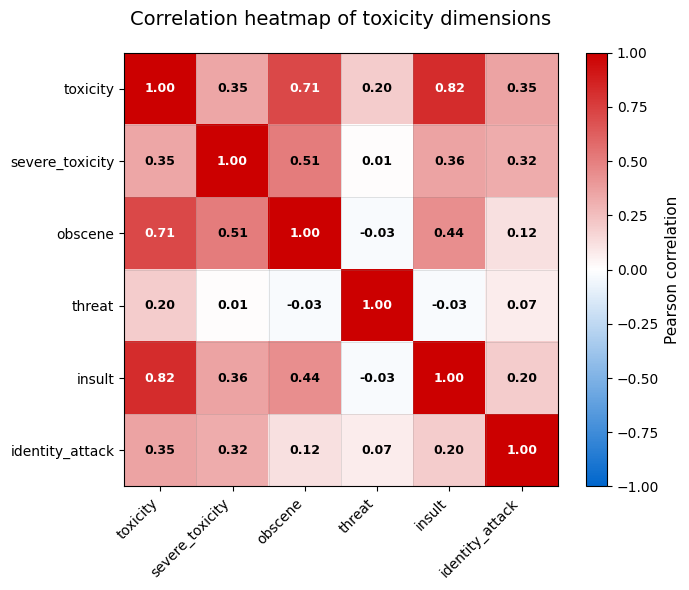

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# === Carica dati ===
path = "Database/classification_results_by_category.csv"
df = pd.read_csv(path)

features = ["toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack"]

# === Matrice di correlazione (Pearson) ===
corr = df[features].astype(float).corr(method="pearson")

# === Colormap personalizzata: Blu (-1) -> Grigio chiaro (0) -> Rosso (1) ===
# Uso grigio chiaro invece di bianco per compatibilità con dark mode
colors = ['#0066CC', '#FFFFFF', '#CC0000']  # Blu, Grigio chiaro, Rosso
n_bins = 256
cmap = LinearSegmentedColormap.from_list('custom_bwr', colors, N=n_bins)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')
ax.set_facecolor('white')
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
im = ax.imshow(corr.values, cmap=cmap, norm=norm)

# Assi e tick
ax.set_xticks(range(len(features)))
ax.set_yticks(range(len(features)))
ax.set_xticklabels(features, rotation=45, ha="right", fontsize=10)
ax.set_yticklabels(features, fontsize=10)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Pearson correlation", fontsize=11)

# Etichette numeriche con colore adattivo migliorato
for i in range(len(features)):
    for j in range(len(features)):
        v = corr.values[i, j]
        # Logica per il colore del testo basata sul valore di correlazione
        if abs(v) > 0.7:  # Correlazioni molto forti: testo bianco
            text_color = "white"
        elif abs(v) < 0.2:  # Correlazioni deboli (vicino al bianco): testo nero
            text_color = "black"
        else:  # Correlazioni medie: testo scuro per visibilità
            text_color = "black"

        ax.text(j, i, f"{v:.2f}", ha="center", va="center",
               fontsize=9, color=text_color, weight="bold")

# Griglia sottile per separare le celle
ax.set_xticks(np.arange(len(features)) - 0.5, minor=True)
ax.set_yticks(np.arange(len(features)) - 0.5, minor=True)
ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5, alpha=0.3)
ax.tick_params(which="minor", size=0)

ax.set_title("Correlation heatmap of toxicity dimensions", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

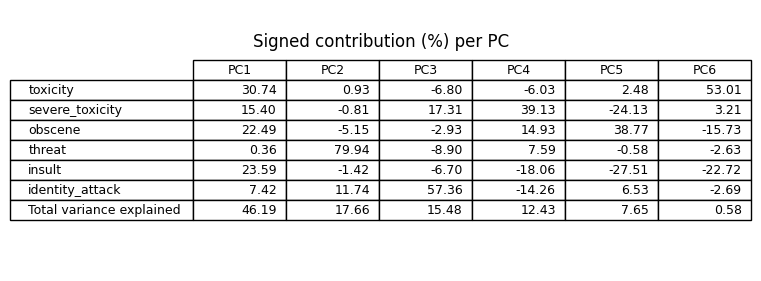

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# === Carica i dati ===
path = "Database/classification_results_by_category.csv"
df = pd.read_csv(path)

features = ["toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack"]

X = df[features].astype(float).values
Xz = StandardScaler().fit_transform(X)

# === PCA con 6 componenti ===
pca = PCA(n_components=6, random_state=0)
Z = pca.fit_transform(Xz)

# === Loadings (coeff. di correlazione tra variabile e componente) ===
loadings = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=[f"PC{i+1}" for i in range(6)]
)

# --- Contributi "signed": segno del loading * contributo percentuale ---
sq = loadings ** 2
abs_contrib_pct = sq.div(sq.sum(axis=0), axis=1) * 100
signed_contrib_pct = np.sign(loadings) * abs_contrib_pct

# --- Aggiungo riga con varianza spiegata ---
signed_contrib_pct.loc["Total variance explained"] = pca.explained_variance_ratio_ * 100

# === Funzione per mostrare tabella con titolo "mezza via" ===
def show_table(df: pd.DataFrame, title: str = None, floatfmt: str = "{:.2f}"):
    df_to_show = df.copy()
    for col in df_to_show.columns:
        df_to_show[col] = df_to_show[col].apply(
            lambda x: floatfmt.format(x) if isinstance(x, (int, float, np.floating)) and np.isfinite(x) else str(x)
        )

    n_rows, n_cols = df_to_show.shape

    # dimensioni proporzionali
    cell_w, cell_h = 1.2, 0.4
    fig_w = max(6, n_cols * cell_w)
    fig_h = max(2.5, n_rows * cell_h + 0.6)

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.axis("off")

    # crea tabella
    table = ax.table(
        cellText=df_to_show.values,
        rowLabels=df_to_show.index.astype(str),
        colLabels=df_to_show.columns.astype(str),
        loc="center"
    )

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.2)

    # Calcola posizione della tabella e aggiungi titolo un po' più distante
    if title:
        fig.canvas.draw()
        bbox = table.get_window_extent(fig.canvas.get_renderer())
        inv = fig.transFigure.inverted()
        bbox_fig = inv.transform(bbox)
        xmid = (bbox_fig[0, 0] + bbox_fig[1, 0]) / 2
        ytop = bbox_fig[1, 1]
        fig.text(xmid, ytop + 0.03, title, ha="center", va="bottom", fontsize=12)

    plt.show()

# === Mostra SOLO la tabella signed ===
show_table(signed_contrib_pct, title="Signed contribution (%) per PC")


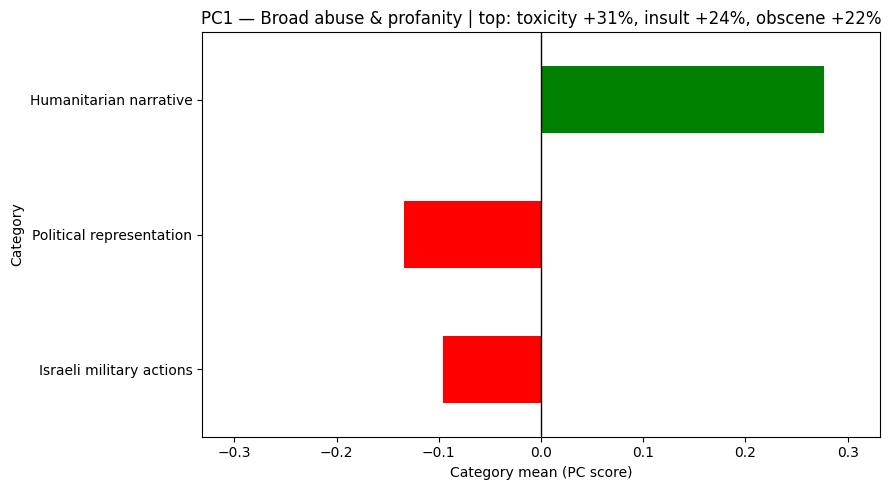

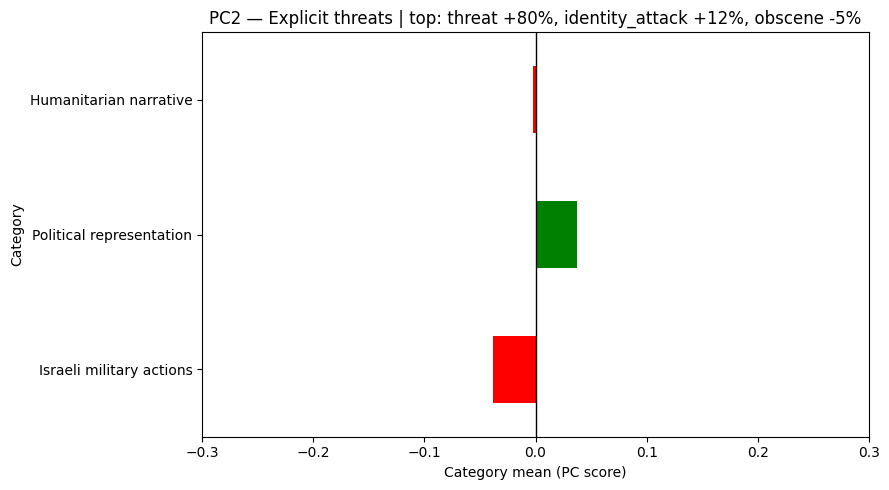

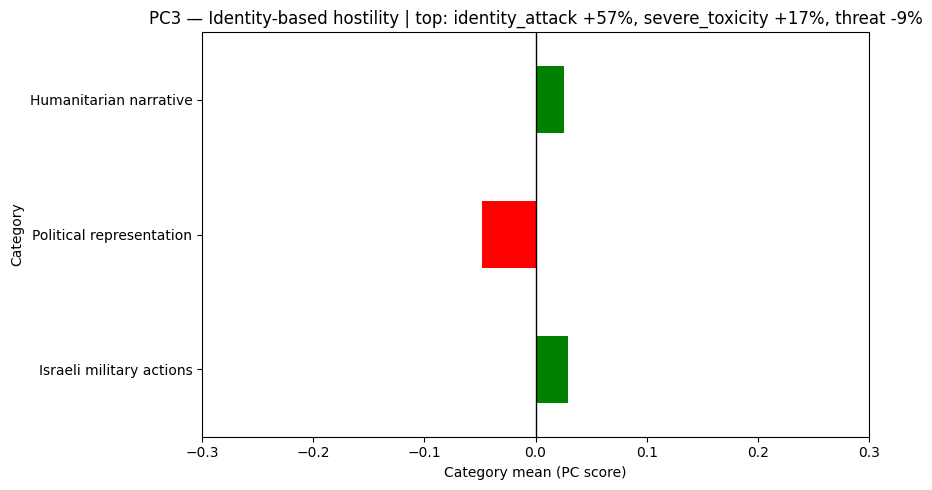

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# === Load data ===
path = "Database/classification_results_by_category.csv"
df = pd.read_csv(path)

features = ["toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack"]

# Preserve a consistent category order (first appearance in the file)
category_order = pd.Index(df["category"].dropna().unique())

# === PCA (3 components) ===
X = df[features].astype(float).values
Xz = StandardScaler().fit_transform(X)

pca = PCA(n_components=3, random_state=0)
Z = pca.fit_transform(Xz)

# Loadings (feature weights per PC)
loadings = pd.DataFrame(pca.components_.T, index=features, columns=["PC1", "PC2", "PC3"])
explained = pca.explained_variance_ratio_

# --- Sign convention: make the largest-abs loading positive for each PC
for comp in ["PC1", "PC2", "PC3"]:
    top_feat = loadings[comp].abs().idxmax()
    if np.sign(loadings.loc[top_feat, comp]) < 0:
        loadings[comp] *= -1
        Z[:, int(comp[-1]) - 1] *= -1

# === Percent contribution table (squared-loadings normalized to 100%)
sq = loadings**2
contrib = 100 * sq / sq.sum(axis=0)
contrib = contrib.reindex(features)

# Add scores back
df["PC1"], df["PC2"], df["PC3"] = Z[:, 0], Z[:, 1], Z[:, 2]

# === Category means with fixed order ===
df["_category_ordered"] = pd.Categorical(df["category"], categories=category_order, ordered=True)
scores_mean = (
    df.groupby("_category_ordered", sort=False, observed=False)[["PC1", "PC2", "PC3"]]
      .mean()
      .rename_axis("category")
)

# === Human-readable titles: show TOP contributions with sign
def comp_label(name: str, load_col: pd.Series, contrib_col: pd.Series, k: int = 3) -> str:
    desc_map = {
        "PC1": "Broad abuse & profanity",
        "PC2": "Explicit threats",
        "PC3": "Identity-based hostility",
    }
    desc = desc_map.get(name, name)

    # Top-k by absolute magnitude of loading
    top_idx = load_col.abs().sort_values(ascending=False).index[:k]

    parts = []
    for feat in top_idx:
        sign = "+" if load_col.loc[feat] >= 0 else "-"
        pct = contrib_col.loc[feat]
        parts.append(f"{feat} {sign}{pct:.0f}%")

    top_txt = ", ".join(parts)
    return f"{name} — {desc} | top: {top_txt}"

titles = {
    "PC1": comp_label("PC1", loadings["PC1"], contrib["PC1"]),
    "PC2": comp_label("PC2", loadings["PC2"], contrib["PC2"]),
    "PC3": comp_label("PC3", loadings["PC3"], contrib["PC3"]),
}

# === Plot: horizontal bars with zero centered; green for >0, red for <0 ===
for comp in ["PC1", "PC2", "PC3"]:
    series = scores_mean[comp].reindex(category_order)

    colors = ["green" if v >= 0 else "red" for v in series.values]
    ax = series.plot(
        kind="barh",
        figsize=(9, 5),
        color=colors,
        title=titles[comp],
        legend=False
    )
    max_abs = float(np.nanmax(np.abs(series.values))) if np.isfinite(series.values).any() else 0.0
    lim = max(0.3, max_abs * 1.2)
    ax.set_xlim(-lim, lim)
    ax.axvline(0, color="black", linewidth=1)
    ax.set_xlabel("Category mean (PC score)")
    ax.set_ylabel("Category")
    plt.tight_layout()
    plt.show()


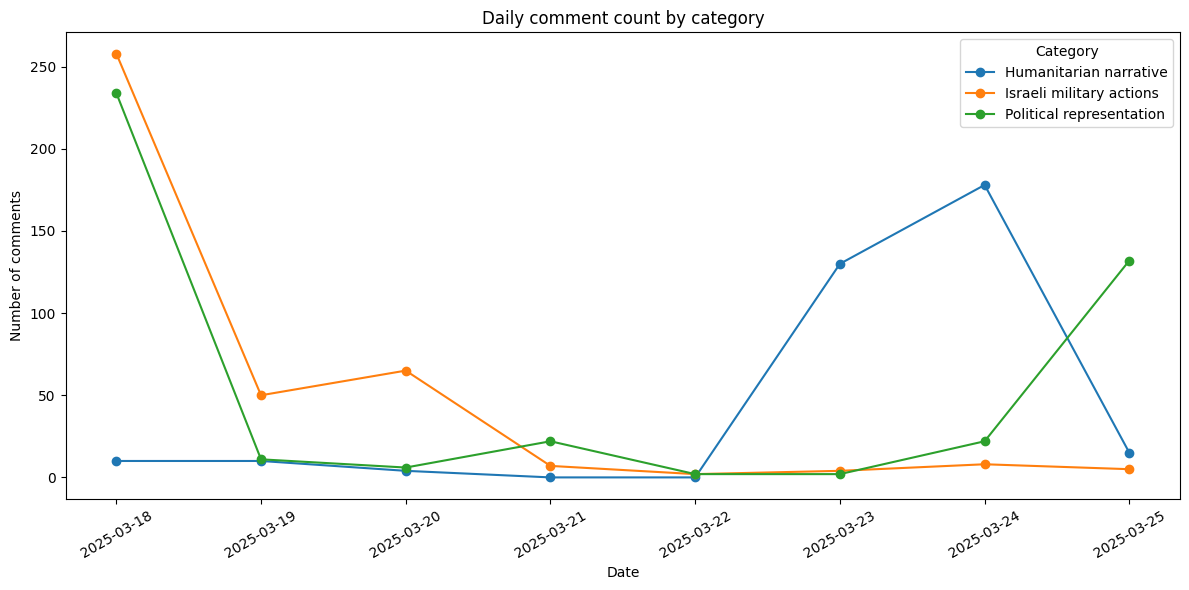

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load data ===
# Replace the path with your actual file location
path = "Database/classification_results_by_category.csv"
df = pd.read_csv(path)

# === Prep datetime ===
# Convert timestamps and ensure UTC
df["published_at"] = pd.to_datetime(df["published_at"], utc=True, errors="coerce")

# Drop rows without valid timestamp or category
df = df.dropna(subset=["published_at", "category"])

# Extract the calendar day (YYYY-MM-DD)
df["date"] = df["published_at"].dt.date

# === Aggregate daily counts by category ===
daily_counts = (
    df.groupby(["date", "category"])
      .size()
      .reset_index(name="count")
)

# Pivot table to have one column per category
wide = daily_counts.pivot(index="date", columns="category", values="count").fillna(0)

# === Plot ===
fig, ax = plt.subplots(figsize=(12, 6))

# Plot one line per category
for category in wide.columns:
    ax.plot(wide.index, wide[category], marker="o", linestyle="-", label=category)

# Titles and labels
ax.set_title("Daily comment count by category")
ax.set_xlabel("Date")
ax.set_ylabel("Number of comments")
ax.legend(title="Category")

# Rotate x-axis labels for readability
plt.xticks(rotation=30)
plt.tight_layout()

# Show plot
plt.show()


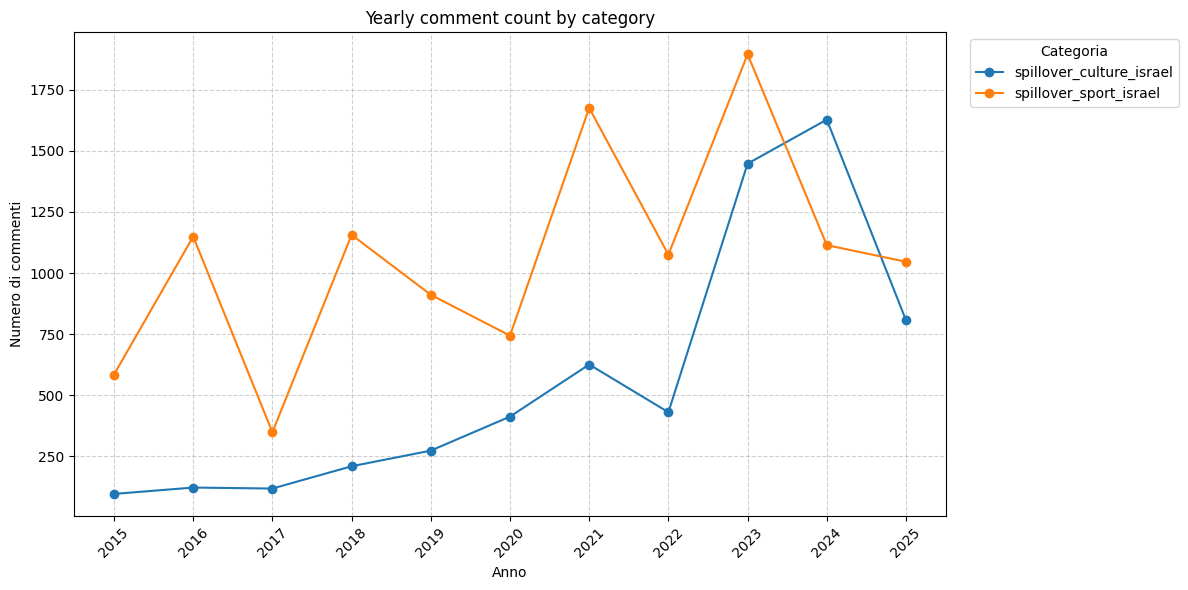

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Config
# =========================
spillover_path = "Database/classification_results_spillover.csv"
features = ["toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack"]

# =========================
# Load & prepare (stessi filtri)
# =========================
df = pd.read_csv(spillover_path)

# Normalize/clean category labels
df["category"] = df["category"].astype(str).str.strip()

# Detect [removed]
mask_removed = df["text"].astype(str).str.strip().str.lower().eq("[removed]")

# Ensure numeric
for f in features:
    df[f] = pd.to_numeric(df[f], errors="coerce")

# Set [removed] ai 99° percentile per variabile (coerenza pipeline)
q99_map = {}
for f in features:
    non_removed_vals = df.loc[~mask_removed, f]
    q = non_removed_vals.quantile(0.99)
    if pd.isna(q):
        q = 1.0
    q99_map[f] = float(q)
    df.loc[mask_removed, f] = q

# Parse timestamps, keep valid, deduplicate
df["published_at"] = pd.to_datetime(df["published_at"], errors="coerce")
df = df.dropna(subset=["published_at"])
df = df.drop_duplicates(subset=["post_id", "published_at", "text"])

# Year + filtro anni
df["year"] = df["published_at"].dt.year
df = df[df["year"] >= 2015].reset_index(drop=True)

# =========================
# Aggregate: numero commenti per anno e categoria
# =========================
comments_per_year_cat = (
    df.groupby(["year", "category"])
      .size()
      .rename("n_comments")
      .reset_index()
      .sort_values(["year", "category"])
)

# Pivot per plotting
pivot_counts = comments_per_year_cat.pivot(index="year", columns="category", values="n_comments").fillna(0)

# =========================
# Plot: linee per categoria
# =========================
plt.figure(figsize=(12, 6))

colors = plt.cm.tab10.colors
color_map = {cat: colors[i % len(colors)] for i, cat in enumerate(pivot_counts.columns)}

for category in pivot_counts.columns:
    plt.plot(
        pivot_counts.index,
        pivot_counts[category],
        marker="o",
        linestyle="-",
        color=color_map[category],
        label=category
    )

plt.title("Yearly comment count by category")
plt.xlabel("Anno")
plt.ylabel("Numero di commenti")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(pivot_counts.index, rotation=45)
plt.legend(title="Categoria", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

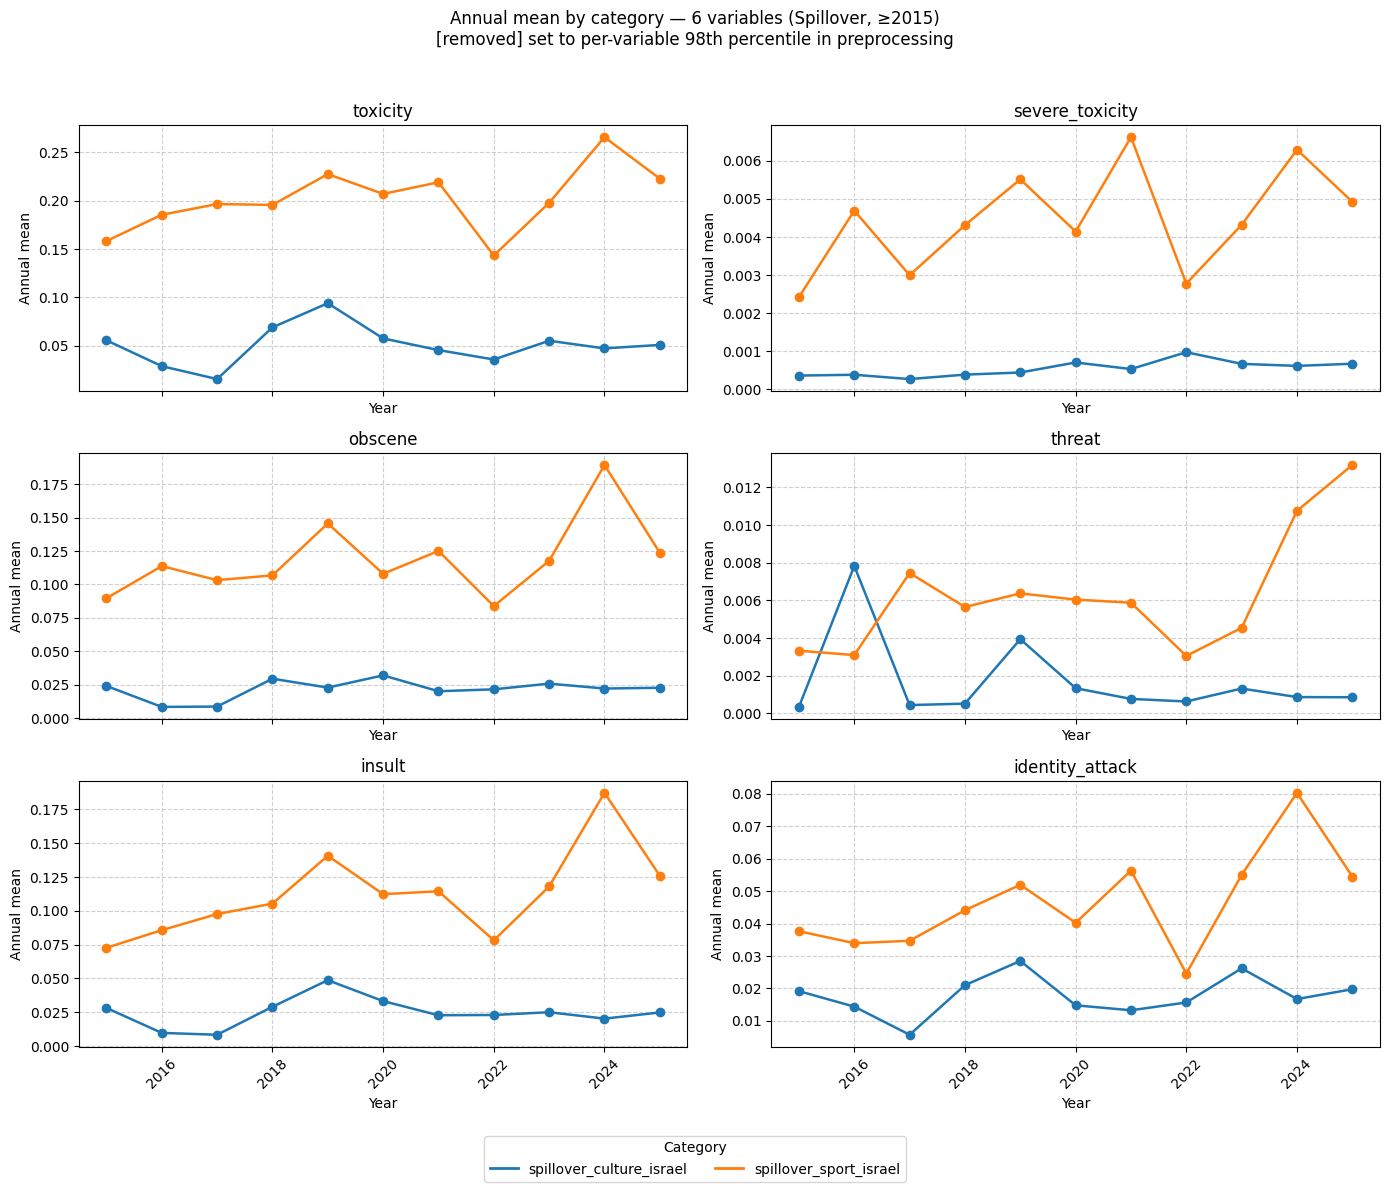

In [5]:
# =========================
# 3x2: una variabile per subplot, linee per categoria (media annuale)
# =========================

# (ri)costruzione media annuale per (year, category) e filtro anni ≥2015
annual_cat = (
    df.groupby(["year", "category"])[features]
      .mean()
      .reset_index()
)
annual_cat = annual_cat[annual_cat["year"] >= 2015].sort_values(["year", "category"]).reset_index(drop=True)

# Ordine categorie coerente alla prima apparizione
cat_order = pd.Index(annual_cat["category"].astype(str).dropna().unique())

# Prepara i pivot (uno per feature): righe=year, colonne=category
pivots = {}
for f in features:
    piv = (
        annual_cat[["year", "category", f]]
        .assign(category=lambda x: x["category"].astype(str).str.strip())
        .pivot(index="year", columns="category", values=f)
        .reindex(columns=cat_order)
        .sort_index()
    )
    pivots[f] = piv

# Plot 3x2
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True)
axes = axes.ravel()

# Palette (cycler su più colori se categorie > 10)
base_colors = list(plt.cm.tab10.colors) + list(plt.cm.Set2.colors) + list(plt.cm.Dark2.colors)
color_map = {cat: base_colors[i % len(base_colors)] for i, cat in enumerate(cat_order)}

present_cats = set()

for i, f in enumerate(features):
    ax = axes[i]
    piv = pivots[f]
    for cat in piv.columns:
        series = piv[cat].dropna()
        if series.empty:
            continue
        ax.plot(series.index, series.values, marker="o", linewidth=1.8, label=cat, color=color_map[cat])
        present_cats.add(cat)

    ax.set_title(f)
    ax.set_xlabel("Year")
    ax.set_ylabel("Annual mean")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.tick_params(axis="x", rotation=45)

# Legenda condivisa (solo categorie presenti)
handles = [plt.Line2D([0], [0], color=color_map[c], lw=2) for c in cat_order if c in present_cats]
labels  = [c for c in cat_order if c in present_cats]
if handles:
    fig.legend(handles, labels, loc="lower center", ncol=min(6, len(labels)), title="Category")

plt.suptitle(
    "Annual mean by category — 6 variables (Spillover, ≥2015)\n"
    "[removed] set to per-variable 98th percentile in preprocessing",
    y=0.98
)
plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()


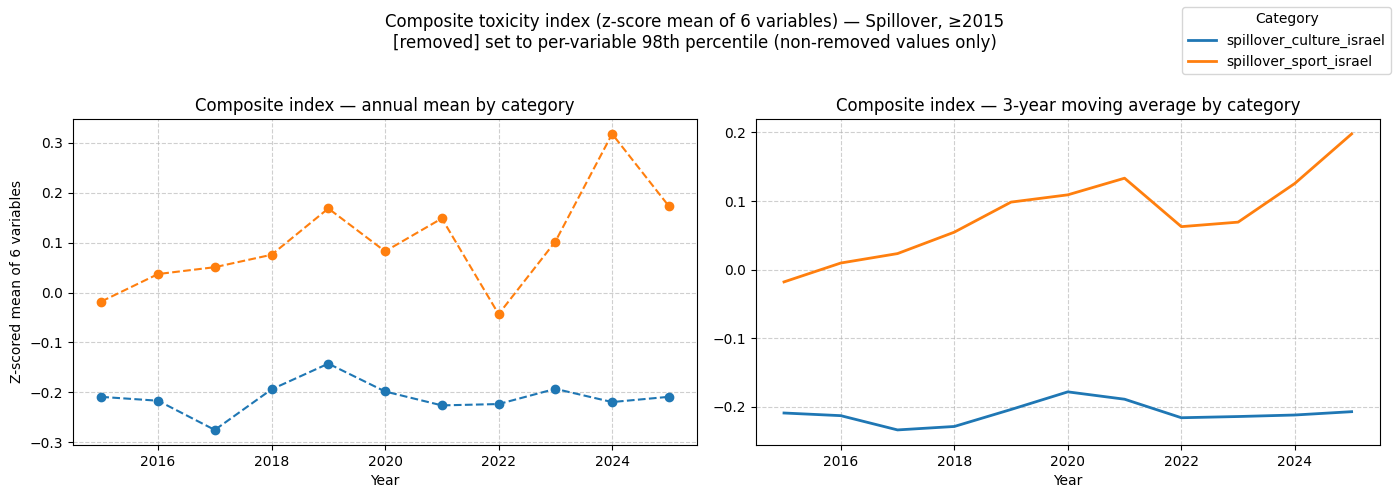

98th percentiles used for assigning [removed]:
  toxicity: 0.9880
  severe_toxicity: 0.0310
  obscene: 0.9405
  threat: 0.0250
  insult: 0.8740
  identity_attack: 0.4015


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# =========================
# Composite Index = mean of the 6 normalized variables (z-score)
# Rules:
# - [removed] values set to the 98th percentile of each variable (calculated on non-removed rows)
# - No PCA
# =========================

# 1) Compute 98th percentile on NON-removed and assign it to removed rows
p98_map = {}
for f in features:
    non_removed_vals = pd.to_numeric(df.loc[~mask_removed, f], errors="coerce")
    p98 = float(non_removed_vals.quantile(0.98))
    p98_map[f] = p98
    df.loc[mask_removed, f] = p98  # assign p98 to removed rows

# 2) Standardize the 6 features (z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# 3) Composite index = row-wise mean of the 6 z-scores
df["composite_index"] = X_scaled.mean(axis=1)

# 4) Aggregate: annual mean per category (year ≥ 2015)
annual_idx = (
    df.groupby(["year", "category"])["composite_index"]
      .mean()
      .reset_index()
)
annual_idx = annual_idx[annual_idx["year"] >= 2015].sort_values(["year", "category"]).reset_index(drop=True)

# 5) Pivot for plotting and 3-year moving average
cat_order = pd.Index(annual_idx["category"].astype(str).dropna().unique())
piv = (
    annual_idx.pivot(index="year", columns="category", values="composite_index")
              .reindex(columns=cat_order)
              .sort_index()
)
ma3 = piv.rolling(window=3, min_periods=1).mean()

# 6) Plot 1x2: left = annual values (dashed), right = 3-year MA (solid)
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# color palette
base_colors = list(plt.cm.tab10.colors) + list(plt.cm.Set2.colors) + list(plt.cm.Dark2.colors)
color_map = {cat: base_colors[i % len(base_colors)] for i, cat in enumerate(cat_order)}

# Left: annual values
ax_left = axes[0]
for cat in piv.columns:
    s = piv[cat].dropna()
    if s.empty:
        continue
    ax_left.plot(s.index, s.values, linestyle="--", marker="o", label=cat, color=color_map[cat])
ax_left.set_title("Composite index — annual mean by category")
ax_left.set_xlabel("Year")
ax_left.set_ylabel("Z-scored mean of 6 variables")
ax_left.grid(True, linestyle="--", alpha=0.6)

# Right: 3-year moving average
ax_right = axes[1]
for cat in ma3.columns:
    s = ma3[cat].dropna()
    if s.empty:
        continue
    ax_right.plot(s.index, s.values, linestyle="-", linewidth=2, label=cat, color=color_map[cat])
ax_right.set_title("Composite index — 3-year moving average by category")
ax_right.set_xlabel("Year")
ax_right.grid(True, linestyle="--", alpha=0.6)

# Shared legend (upper right)
handles = [plt.Line2D([0], [0], color=color_map[c], lw=2) for c in cat_order]
labels = [c for c in cat_order]
fig.legend(handles, labels, loc="upper right", title="Category")

plt.suptitle(
    "Composite toxicity index (z-score mean of 6 variables) — Spillover, ≥2015\n"
    "[removed] set to per-variable 98th percentile (non-removed values only)",
    y=0.98
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# (optional) print the 98th percentiles used
print("98th percentiles used for assigning [removed]:")
for k, v in p98_map.items():
    print(f"  {k}: {v:.4f}")
